In [20]:
from multissl.models import FeaturePCA
from multissl.data import OrthoChipDataset
from multissl.eval.ortho_reconstruct import reconstruct_ortho_from_predictions 
from torchvision import transforms
from torch.utils.data import DataLoader
import os
from multissl.plotting.false_color import visualize_features_from_model

In [21]:
CONFIG = {
    # Dataset parameters
    "img_dir": "../dataset/vineseg/imgs",  # Update with your path
    "mask_dir": "../dataset/vineseg/masks",  # Update with your path
    "unlabeled_dir": ["../dataset/vineseg/imgs/train_qbaixo5","../dataset/vineseg/imgs/train_valdoeiro5",  ],  # Optional path or list of paths to unlabeled images
    "img_size": 224,
    "batch_size": 4,
    "num_workers": 0,
    
    # Model parameters
    "pretrained_checkpoint": "../checkpoints_swin/last.ckpt",
    "backbone_type": "swin-tiny",  # Options: resnet18, resnet50, vit-s, swin-tiny
    "num_classes": 2,
    "in_channels": 4,  # 4 channels for R+G+RE+NIR
    "hidden_dim": 256,
    
    # Training parameters
    "epochs": 300,
    "lr": 3e-4,
    "weight_decay": 1e-4,
    "consistency_weight": 1.0,
    "consistency_rampup": 10,  # Epochs for ramping up consistency weight
    "check_val_every_n_epoch": 5,  # Validate every N epochs
    
    # Domain adaptation parameters
    "unfreeze_backbone_after": None,  # Unfreeze backbone after this many epochs (None to keep frozen)
    
    # Misc
    "seed": 42,
    "class_names": ["Background", "Vines"],  # Update with your class names
    "checkpoint_dir": "domain_adaptive_checkpoints",
    "project_name": "1SHOT_Segmentation",
    "class_names": ["Background","Vines"],  # Update with your class names
    "class_weights": [1.0,1.0],

}

In [22]:
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon

def buffer_geometry(geom, buffer_amount=3):
    """
    Expand the geometry by adding buffer_amount to max coordinates 
    and subtracting buffer_amount from min coordinates
    """
    if geom.is_empty:
        return geom
        
    # Get the minimum and maximum coordinates
    minx, miny, maxx, maxy = geom.bounds
    
    # Create a new rectangle with buffered bounds
    buffered_box = Polygon([
        (minx - buffer_amount, miny - buffer_amount),
        (maxx + buffer_amount, miny - buffer_amount),
        (maxx + buffer_amount, maxy + buffer_amount),
        (minx - buffer_amount, maxy + buffer_amount)
    ])
    
    # Get the union of the original geometry with the buffered box
    # Using union instead of intersection to expand the geometry
    result = geom.union(buffered_box)
    
    # If the result is a Polygon and the original was a MultiPolygon, 
    # convert back to MultiPolygon for consistency
    if isinstance(geom, MultiPolygon) and isinstance(result, Polygon):
        result = MultiPolygon([result])
        
    return result




In [23]:
import xarray as xr
import rioxarray as rxr
import uavgeo as ug
import numpy as np
import geopandas as gpd


ortho = "../dataset/altum_vineyard_segmentation/esac/altum/ortho.tif"
mask = "../dataset/altum_vineyard_segmentation/esac/altum/mask.png"

esac_ortho = rxr.open_rasterio(ortho, masked =True)



bands = [2,3,4,5] #(GREEN, RED,REDEDGE,NIR)
esac_ortho = esac_ortho.sel(band=bands)
esac_ortho = 255.0 * (esac_ortho - esac_ortho.min()) / (esac_ortho.max() - esac_ortho.min())
esac_ortho = esac_ortho.astype(np.uint8)

# Make esac 1 and esac 2, like the study
esac_shp = gpd.read_file("../dataset/altum_vineyard_segmentation/esac/esac12.geojson")
esac1_geom = esac_shp.geometry[esac_shp["id"]==1]
esac2_geom = esac_shp.geometry[esac_shp["id"]==2]
# Apply this function to your GeoDataFrame
# Assuming your GeoDataFrame is called 'gdf'
# Apply to your GeoSeries
esac1_geom = esac1_geom.apply(lambda geom: buffer_geometry(geom, 3))
esac2_geom = esac2_geom.apply(lambda geom: buffer_geometry(geom, 3))
esac1_ortho = esac_ortho.rio.clip(esac1_geom.values, esac_shp.crs)
esac2_ortho = esac_ortho.rio.clip(esac2_geom.values, esac_shp.crs)



qbaixo_ortho = rxr.open_rasterio(ortho.replace("esac", "qbaixo"), masked =True)
qbaixo_mask =rxr.open_rasterio(mask.replace("esac", "qbaixo"), masked =True)

valdoeiro_ortho = rxr.open_rasterio(ortho.replace("esac", "valdoeiro"), masked =True)
valdoeiro_mask = rxr.open_rasterio(mask.replace("esac", "valdoeiro").replace(".png", ".tif"), masked =True)

# has some gaping holes (we can fix that later y only selecting chips without edges? hmmm

# aligning the esac mask to ms rasters:
# Esac has the identical shape so we can just plop the values into the shape/crs  
# one layer has all the info we need
qbaixo_mask = qbaixo_mask.sel(band=1)
empty = xr.zeros_like(qbaixo_ortho.sel(band=2))

empty.values =qbaixo_mask.values

qbaixo_mask = empty.copy()

# Get the shapes of both rasters
ortho_shape = valdoeiro_ortho.shape
mask_shape = valdoeiro_mask.shape

# Calculate the difference in size
height_diff = ortho_shape[1] - mask_shape[1]  # Difference in y dimension
width_diff = ortho_shape[2] - mask_shape[2]   # Difference in x dimension

# Crop the ortho to match the mask size, keeping the alignment from top right
# This means we'll remove pixels from the bottom and left
cropped_ortho = valdoeiro_ortho.isel(
    y=slice(0, mask_shape[1]),           # Keep the top portion
    x=slice(width_diff, ortho_shape[2])  # Keep the right portion
)
empty = xr.zeros_like(cropped_ortho.sel(band=2))

empty.values =valdoeiro_mask.sel(band=1).values

valdoeiro_mask = empty.copy()
valdoeiro_ortho = cropped_ortho.copy()

valdoeiro_ortho = valdoeiro_ortho.sel(band=bands)
valdoeiro_ortho = 255.0 * (valdoeiro_ortho - valdoeiro_ortho.min()) / (valdoeiro_ortho.max() - valdoeiro_ortho.min())
valdoeiro_ortho = valdoeiro_ortho.astype(np.uint8)

qbaixo_ortho = qbaixo_ortho.sel(band=bands)
qbaixo_ortho = 255.0 * (qbaixo_ortho - qbaixo_ortho.min()) / (qbaixo_ortho.max() - qbaixo_ortho.min())
qbaixo_ortho = qbaixo_ortho.astype(np.uint8)

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\xarray\core\duck_array_ops.py:239: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\xarray\core\duck_array_ops.py:239: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\xarray\core\duck_array_ops.py:239: Runt

In [24]:
ortho_dataset_e1 = OrthoChipDataset(ortho = esac1_ortho,
        img_size= (224, 224),
        remove_empty_chips = True,
        empty_threshold = 1)

ortho_dataset_e2 = OrthoChipDataset(ortho = esac2_ortho,
        img_size= (224, 224),
        remove_empty_chips = True,
        empty_threshold = 1)



ortho_dataset_v = OrthoChipDataset(ortho = valdoeiro_ortho,
        img_size= (224, 224),
        remove_empty_chips = True,
        empty_threshold = 1)

ortho_dataset_q = OrthoChipDataset(ortho = qbaixo_ortho,
        img_size= (224, 224),
        remove_empty_chips = True,
        empty_threshold = 1)




In [6]:
swinmodel = FeaturePCA(backbone_type=CONFIG["backbone_type"],
        pretrained_path=CONFIG["pretrained_checkpoint"],
        in_channels=CONFIG["in_channels"],
        layer="stem",
        out_channels=3,
        img_size=CONFIG["img_size"],
        lr=1e-4,
        weight_decay=1e-5,
        use_online_pca=False, 
        normalize_output=True
    )

Loaded pretrained weights. Missing keys: 0, Unexpected keys: 0
Feature extractor initialized with stem features:
  - Channels: 96
  - Spatial size: 56x56
  - Original image size: 224x224


In [7]:
r18model = FeaturePCA(backbone_type="resnet18",
        pretrained_path="../checkpoints_r18/last.ckpt",
        in_channels=CONFIG["in_channels"],
        layer="stem",
        out_channels=3,
        img_size=CONFIG["img_size"],
        lr=1e-4,
        weight_decay=1e-5,
        use_online_pca=False, 
        normalize_output=True
    )

Feature extractor initialized with stem features:
  - Channels: 64
  - Spatial size: 112x112
  - Original image size: 224x224


In [25]:
from multissl.eval.ortho_reconstruct import no_interpolate_reconstruct_ortho_from_predictions
e2_pca_swin = no_interpolate_reconstruct_ortho_from_predictions(
    model = swinmodel,
    ortho_dataset = ortho_dataset_e2,
    ortho_template = esac2_ortho,
    batch_size = 1,
    num_workers = 4,
    output_channels=3
)

In [26]:
e1_pca_swin = no_interpolate_reconstruct_ortho_from_predictions(
    model = swinmodel,
    ortho_dataset = ortho_dataset_e1,
    ortho_template = esac1_ortho,
    batch_size = 1,
    num_workers = 4,
    output_channels=3
)

In [27]:
v_pca_swin = no_interpolate_reconstruct_ortho_from_predictions(
    model = swinmodel,
    ortho_dataset = ortho_dataset_v,
    ortho_template = valdoeiro_ortho,
    batch_size = 1,
    num_workers = 4,
    output_channels=3
)

In [ ]:
q_pca_swin = no_interpolate_reconstruct_ortho_from_predictions(
    model = swinmodel,
    ortho_dataset = ortho_dataset_q,
    ortho_template = qbaixo_ortho,
    batch_size = 1,
    num_workers = 4,
    output_channels=3
)

In [ ]:
e1_pca_r18 = no_interpolate_reconstruct_ortho_from_predictions(
    model = r18model,
    ortho_dataset = ortho_dataset_e1,
    ortho_template = esac1_ortho,
    batch_size = 1,
    num_workers = 4,
    output_channels=3
)

In [ ]:
e2_pca_r18 = no_interpolate_reconstruct_ortho_from_predictions(
    model = r18model,
    ortho_dataset = ortho_dataset_e2,
    ortho_template = esac2_ortho,
    batch_size = 1,
    num_workers = 4,
    output_channels=3
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 10))

rgb = e1_pca_swin.values.transpose(1,2,0)
e = [esac1_ortho.x.min(), esac1_ortho.x.max(), 
                       esac1_ortho.y.min(), esac1_ortho.y.max()]
# Display the RGB image
ax.imshow(rgb, extent=e)

# Add a title
plt.title('PCA Features from SWIN-T-tiny-stem')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 10))

rgb = e2_pca_swin.values.transpose(1,2,0)
e = [esac2_ortho.x.min(), esac2_ortho.x.max(), 
                       esac2_ortho.y.min(), esac2_ortho.y.max()]
# Display the RGB image
ax.imshow(rgb, extent=e)

# Add a title
plt.title('PCA Features from SWIN-T-tiny-stem')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 10))

rgb = v_pca_swin.values.transpose(1,2,0)
e = [valdoeiro_ortho.x.min(), valdoeiro_ortho.x.max(), 
                       valdoeiro_ortho.y.min(), valdoeiro_ortho.y.max()]
# Display the RGB image
ax.imshow(rgb, extent=e)

# Add a title
plt.title('PCA Features from SWIN-T-tiny-stem')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 10))

rgb = q_pca_swin.values.transpose(1,2,0)
e = [qbaixo_ortho.x.min(), qbaixo_ortho.x.max(), 
                       qbaixo1_ortho.y.min(), qbaixo_ortho.y.max()]
# Display the RGB image
ax.imshow(rgb, extent=e)

# Add a title
plt.title('PCA Features from SWIN-T-tiny-stem')

plt.tight_layout()
plt.show()

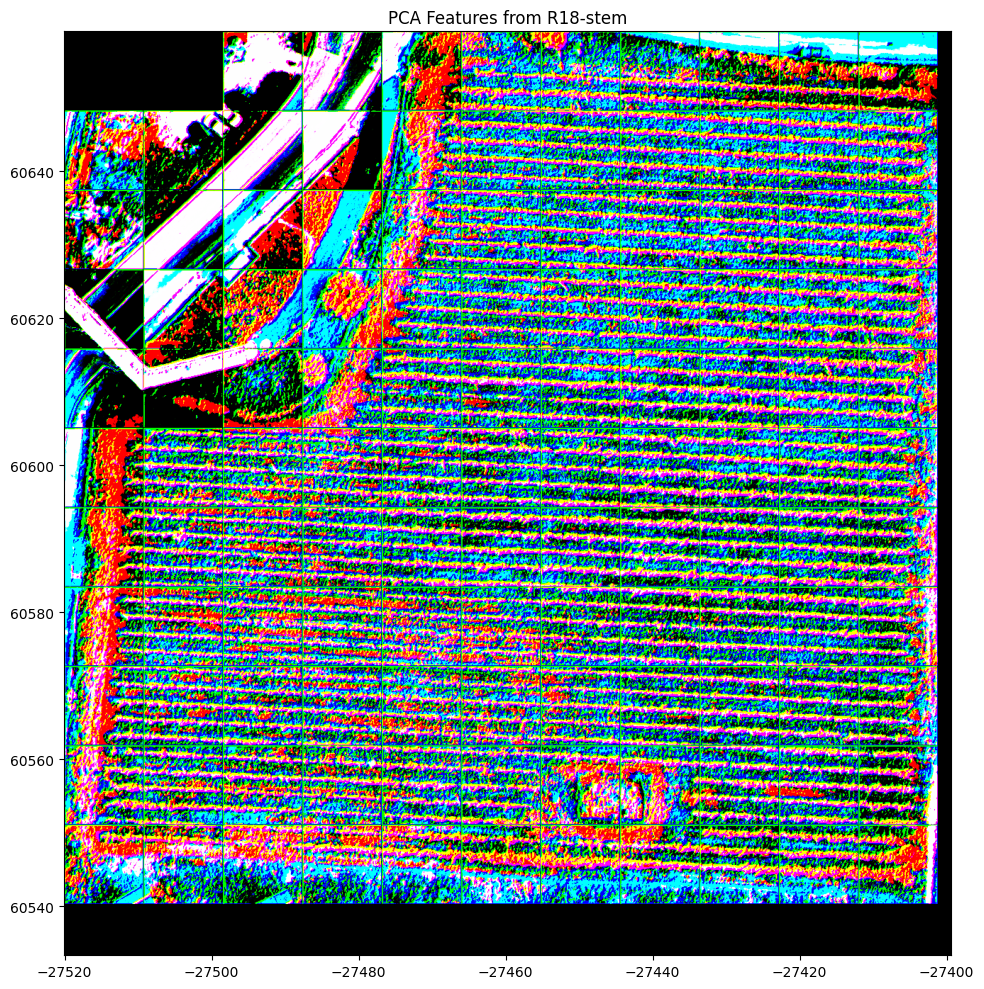

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 10))

rgb = e1_pca_r18.values.transpose(1,2,0)
e = [esac1_ortho.x.min(), esac1_ortho.x.max(), 
                       esac1_ortho.y.min(), esac1_ortho.y.max()]
# Display the RGB image
ax.imshow(rgb, extent=e)

# Add a title
plt.title('PCA Features from R18-stem')

plt.tight_layout()
plt.show()

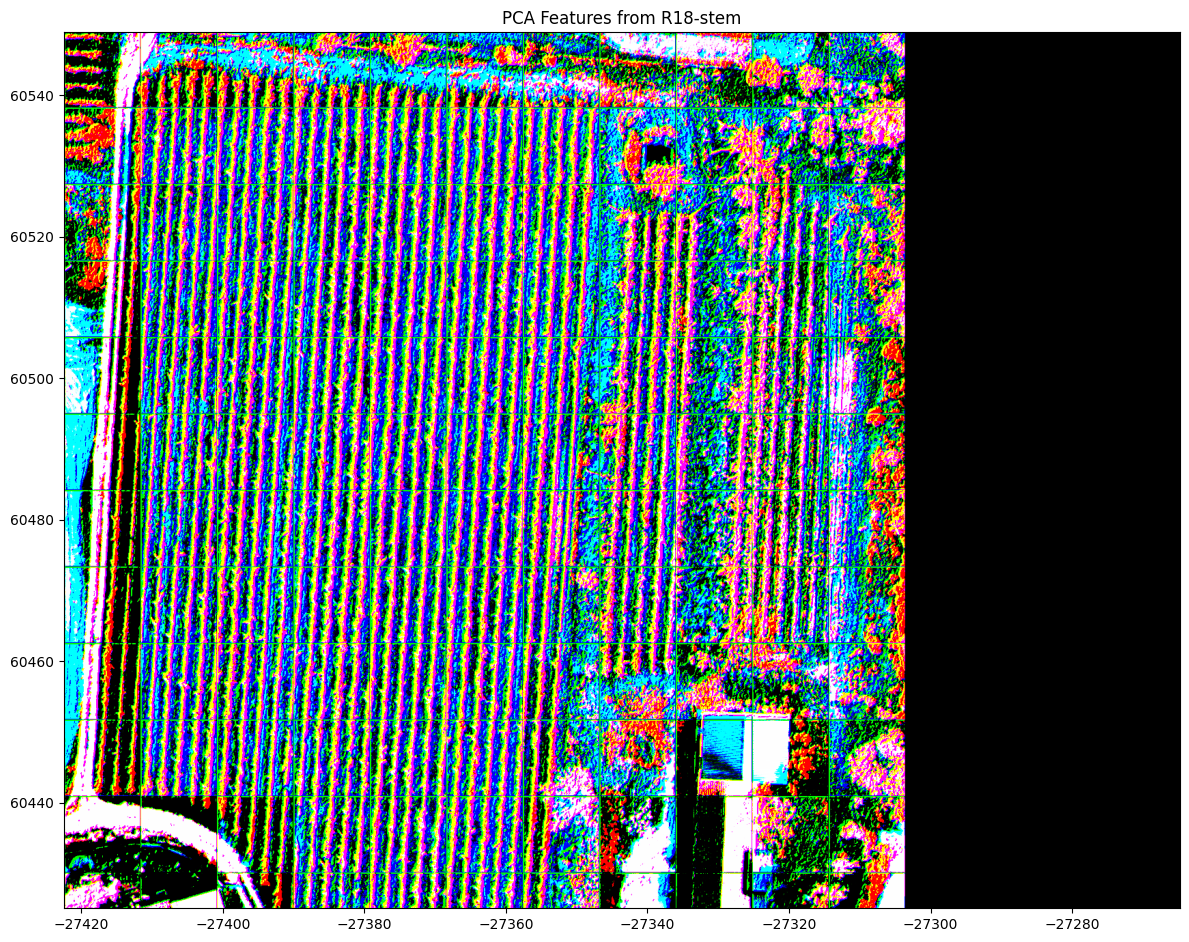

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 10))

rgb = e2_pca_r18.values.transpose(1,2,0)
e = [esac2_ortho.x.min(), esac2_ortho.x.max(), 
                       esac2_ortho.y.min(), esac2_ortho.y.max()]
# Display the RGB image
ax.imshow(rgb, extent=e)

# Add a title
plt.title('PCA Features from R18-stem')

plt.tight_layout()
plt.show()